In [54]:
import sys
sys.path.append('..') 
import os

In [55]:
import psycopg2
from pathlib import Path
import yaml
import pandas as pd
from src.utils.parse_yaml import parse_yaml
from src.db_ops.db_ops import PosgreOps
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

In [56]:
import yaml
def get_config():
    with open("configs/config.yaml", "r") as yamlfile:
        config = yaml.load(yamlfile, Loader=yaml.FullLoader)
        
        yamlfile.close()
    return config

In [57]:
# Load Config
config = get_config()
table_name = "daas.epdk_petrol_province"
size = "" 

## Data Loading

In [58]:
# Initialize Operator
pgops = PosgreOps(config=config)
# Fetch Data
epdk_petrol_province_data = pgops.get_monthly_data(table_name=table_name,
                                                today=date.today(), size=size, months=84)
pgops.shutdown()
print(epdk_petrol_province_data.shape)
print(epdk_petrol_province_data.date.min()," : ",epdk_petrol_province_data.date.max())
print("Number of unique provinces are: ", epdk_petrol_province_data.province.nunique())
epdk_petrol_province_data.head()

(5904, 11)
2016-01-01  :  2022-01-01
Number of unique provinces are:  82


,date,province,gasolene_types,diesel_types,fuel_oil_types,aviation_fuels,marine_fuels,paraffin_oil,other_types,total,percentage
0,2021-01-07,İSTANBUL,64029877.00,309312242.0,227.04,35862161.0,150.0,0.0,0.0,409581321.0,13.87
1,2021-01-07,ANKARA,25824.24,179455388.0,878.72,24629996.0,0.0,0.0,9731034.0,240519377.0,41852.00
2,2021-01-07,İZMİR,23632269.00,119127939.0,96.90,8621778.0,2374391.0,0.0,0.0,153853277.0,44317.00
3,2021-01-07,ANTALYA,15809721.00,85577343.0,200.18,7537775.0,0.0,0.0,0.0,109125019.0,25263.00
4,2021-01-07,BURSA,16221033.00,90476855.0,167.98,175756.0,0.0,0.0,0.0,107041624.0,22706.00


In [59]:
epdk_petrol_province_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            5904 non-null   object 
 1   province        5904 non-null   object 
 2   gasolene_types  5904 non-null   float64
 3   diesel_types    5904 non-null   float64
 4   fuel_oil_types  5890 non-null   float64
 5   aviation_fuels  5875 non-null   float64
 6   marine_fuels    5826 non-null   float64
 7   paraffin_oil    5838 non-null   float64
 8   other_types     5824 non-null   float64
 9   total           5904 non-null   float64
 10  percentage      5904 non-null   float64
dtypes: float64(9), object(2)
memory usage: 507.5+ KB


## Preprocessing

In [60]:
# Drop unnecessary rows
print(epdk_petrol_province_data.shape)
index = epdk_petrol_province_data[epdk_petrol_province_data.province == "Toplam"].index
epdk_petrol_province_data.drop(labels=index, axis=0, inplace=True)
print(epdk_petrol_province_data.shape)
# Check for number of unique provinces
print("Number of unique provinces: ",epdk_petrol_province_data.province.nunique())

(5904, 11)
(5832, 11)
Number of unique provinces:  81


In [61]:
index = epdk_petrol_province_data[epdk_petrol_province_data.province == "Toplam"].index
epdk_petrol_province_data.iloc[index]

,date,province,gasolene_types,diesel_types,fuel_oil_types,aviation_fuels,marine_fuels,paraffin_oil,other_types,total,percentage


In [62]:
# Filter Data
target_columns = ["date","province","diesel_types"]
epdk_petrol_province_data = epdk_petrol_province_data[target_columns].sort_values(by="date")
# epdk_petrol_province_data.sort_values(by="date", inplace=True)
epdk_petrol_province_data.head()

,date,province,diesel_types
5433,2016-01-01,ÇANAKKALE,10286528.00
5434,2016-01-01,ÇANKIRI,3082148.00
5435,2016-01-01,ÇORUM,7218.32
5436,2016-01-01,DENİZLİ,31509926.00
5437,2016-01-01,DİYARBAKIR,9068408.00


### Fix date format

In [63]:
# Fixing date format
epdk_petrol_province_data["date"] = pd.to_datetime(epdk_petrol_province_data["date"], format='%Y-%d-%m')
# epdk_petrol_province_data.date = epdk_petrol_province_data.date.dt.strftime("%Y-%d-%m")
# epdk_petrol_province_data["date"] = pd.to_datetime(epdk_petrol_province_data["date"])
epdk_petrol_province_data.head()

,date,province,diesel_types
5433,2016-01-01,ÇANAKKALE,10286528.00
5434,2016-01-01,ÇANKIRI,3082148.00
5435,2016-01-01,ÇORUM,7218.32
5436,2016-01-01,DENİZLİ,31509926.00
5437,2016-01-01,DİYARBAKIR,9068408.00


In [64]:
epdk_petrol_province_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5832 entries, 5433 to 5902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          5832 non-null   datetime64[ns]
 1   province      5832 non-null   object        
 2   diesel_types  5832 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 182.2+ KB


### Fix Column Names

In [65]:
daglar = {"dagkar":"bb","aa":"bb","cc":"dd"}
st ="ff"

st in daglar.keys()

False

In [66]:
# Fix the column names
epdk_petrol_province_data.rename(columns={"diesel_types":"current_month_consumption"}, inplace=True)
epdk_petrol_province_data.head()

,date,province,current_month_consumption
5433,2016-01-01,ÇANAKKALE,10286528.00
5434,2016-01-01,ÇANKIRI,3082148.00
5435,2016-01-01,ÇORUM,7218.32
5436,2016-01-01,DENİZLİ,31509926.00
5437,2016-01-01,DİYARBAKIR,9068408.00


### Anomaly 

In [67]:
def anomaly_correction(df: pd.DataFrame, target_column: str="current_month_consumption"):
    temp_df = df.copy()
    temp_df[target_column] = temp_df[target_column].apply(lambda row:\
        row/1000 if row%1==0 and row > 100000 else row)
    return temp_df

In [68]:
# Initial
epdk_petrol_province_data[(epdk_petrol_province_data.province == "TUNCELİ") & (epdk_petrol_province_data.date < "2019-01-01") & (epdk_petrol_province_data.date > "2018-01-01")].head()

,date,province,current_month_consumption
3441,2018-02-01,TUNCELİ,720999.00
3360,2018-03-01,TUNCELİ,1048486.00
3277,2018-04-01,TUNCELİ,1383.84
3196,2018-05-01,TUNCELİ,1395842.00
3114,2018-06-01,TUNCELİ,1240591.00


In [69]:
epdk_petrol_province_data.query("current_month_consumption%1==0").sort_values(by=["current_month_consumption"]).head(25)

,date,province,current_month_consumption
2773,2018-10-01,ARTVİN,5115.0
1349,2020-10-01,IĞDIR,7641.0
5426,2016-01-01,BAYBURT,496996.0
4442,2017-01-01,BAYBURT,535863.0
5410,2016-02-01,BAYBURT,544527.0
571,2021-01-01,TUNCELİ,545352.0
5902,2022-01-01,BAYBURT,574129.0
572,2021-01-01,BAYBURT,576279.0
4360,2017-02-01,BAYBURT,584765.0
654,2020-01-01,BAYBURT,596298.0


In [70]:
# Anomaly correction
temp_df = epdk_petrol_province_data.copy()
print("Shape before Anomaly Correction: ",temp_df.shape)
temp_df = anomaly_correction(temp_df)
print("Shape after Anomaly Correction: ",temp_df.shape)
temp_df[(temp_df.province == "TUNCELİ") & (temp_df.date < "2019-01-01") & (temp_df.date > "2018-01-01")].head()

Shape before Anomaly Correction:  (5832, 3)
Shape after Anomaly Correction:  (5832, 3)


,date,province,current_month_consumption
3441,2018-02-01,TUNCELİ,720.999
3360,2018-03-01,TUNCELİ,1048.486
3277,2018-04-01,TUNCELİ,1383.840
3196,2018-05-01,TUNCELİ,1395.842
3114,2018-06-01,TUNCELİ,1240.591


In [71]:
temp_df.query("current_month_consumption%1==0").sort_values(by=["current_month_consumption"]).head()

,date,province,current_month_consumption
2773,2018-10-01,ARTVİN,5115.0
1349,2020-10-01,IĞDIR,7641.0


In [72]:
anomaly_corrected_df = anomaly_correction(epdk_petrol_province_data)
print(anomaly_corrected_df.shape)
anomaly_corrected_df.head()

(5832, 3)


,date,province,current_month_consumption
5433,2016-01-01,ÇANAKKALE,10286.528
5434,2016-01-01,ÇANKIRI,3082.148
5435,2016-01-01,ÇORUM,7218.320
5436,2016-01-01,DENİZLİ,31509.926
5437,2016-01-01,DİYARBAKIR,9068.408


## EDA

In [73]:
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
def plot_province(df: pd.DataFrame, col_x: str, col_y: str, province: str, stdev: int=3):
    df_ = df[df["province"] == province]
    print("Shape of dataframe is : ", df_.shape)
    plt.style.use('ggplot')
    plt.figure(figsize=(25,5))
    x = df_[col_x].dt.strftime("%Y-%m-%d")
    y = df_[col_y]
    # Plot x and y
    plt.plot(x,y, "o", color="black", linestyle="--", )
    plt.axhline(y = y.mean(), color = 'gray', linestyle = '--')
    plt.axhline(y = y.mean()+stdev*y.std(), color = 'red', linestyle = '--')
    plt.axhline(y = y.mean()-stdev*y.std(), color = 'red', linestyle = '--')
    # Edit the plot
    plt.tick_params(axis='x',rotation=90)
    plt.legend([col_y,"mean",f"+{stdev} stdev", f"-{stdev} stdev"], loc="best")
    plt.title(province+" "+ df_.date.min().strftime("%Y-%m-%d")+" : "+df_.date.max().strftime("%Y-%m-%d"))
    plt.show()
    pass

Shape of dataframe is :  (72, 3)


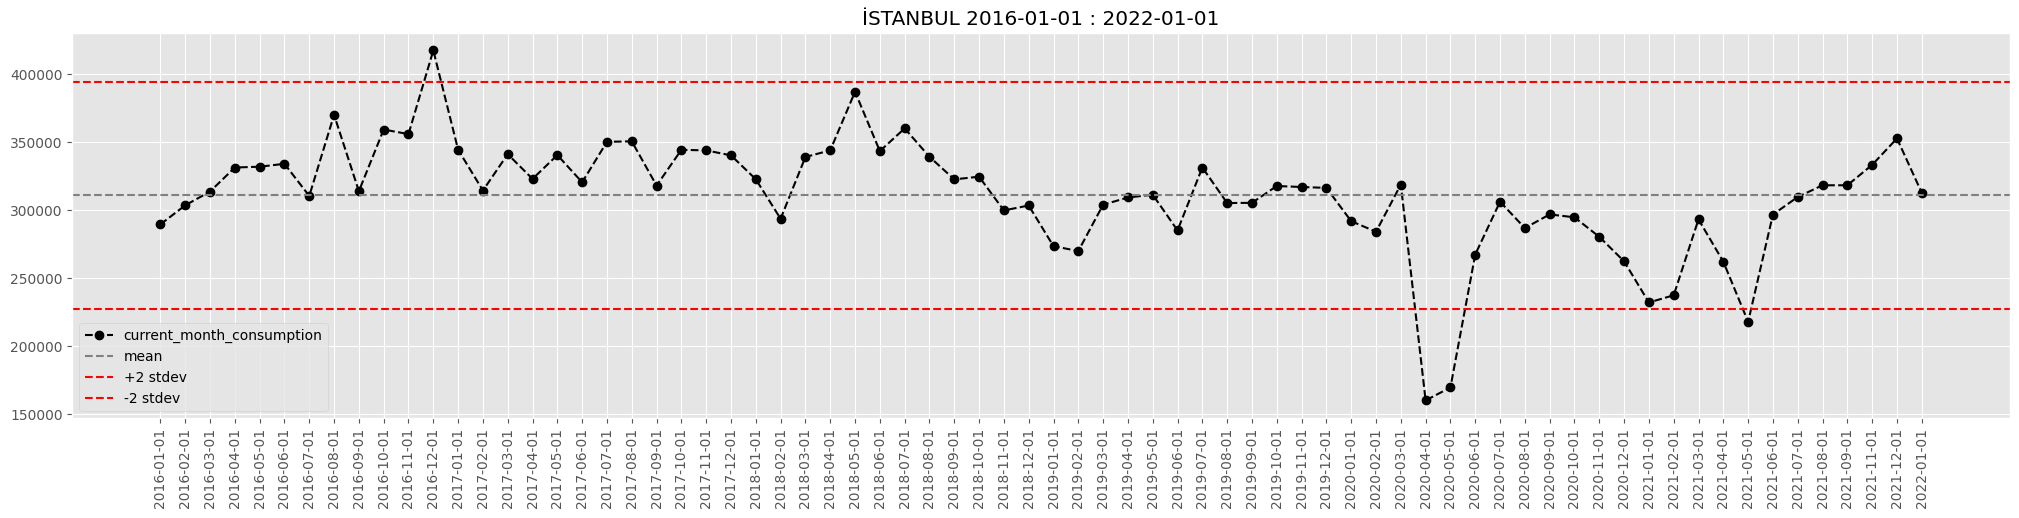

In [74]:
plot_province(df=anomaly_corrected_df, col_x="date", col_y="current_month_consumption", province="İSTANBUL", stdev=2)

## Feature Engineering

### Auto regressive features

In [75]:
def feature_generator(data: pd.DataFrame, num_of_months: int=3):
    empty_df = pd.DataFrame()
    for province in data.province.unique():
        # Filter data by province
        temp_df = data[data.province == province]
        # Reset index
        temp_df = temp_df.reset_index(drop=True)
        # Add last year consumption
        temp_df["last_year_same_month_consumption"] = temp_df.current_month_consumption.shift(12)
        # Add last year total consumption
        temp_df["last_year_total_consumption"] = temp_df.current_month_consumption.rolling(window=12,closed="left").sum()
        # Monthly Share for current consumption
        temp_df["current_month_share"] = temp_df["current_month_consumption"]/temp_df["last_year_total_consumption"]
        # Add previous month shares
        for i in range(num_of_months):
            col_name = f"previous_{i+1}_month_share"
            temp_df[col_name] = temp_df.current_month_share.shift(i+1)
    
        # # Add year
        # temp_df["year"] = temp_df["date"].dt.year
        # # Add month
        # temp_df["month"] = temp_df["date"].dt.month
        # Add quarter of the year
        temp_df['quarter'] = temp_df['date'].dt.quarter
        
        empty_df = pd.concat([empty_df,temp_df], ignore_index=True)
    return empty_df

In [76]:
arf_added_df = feature_generator(anomaly_corrected_df)
print(arf_added_df.shape)
arf_added_df.head()

(5832, 10)


,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,quarter
0,2016-01-01,ÇANAKKALE,10286.528,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2016-02-01,ÇANAKKALE,12624.107,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2016-03-01,ÇANAKKALE,12803.444,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2016-04-01,ÇANAKKALE,15072.013,NaN,NaN,NaN,NaN,NaN,NaN,2
4,2016-05-01,ÇANAKKALE,14431.288,NaN,NaN,NaN,NaN,NaN,NaN,2


### Add Pandemic Interval

In [77]:
# Add pandemic interval
# https://www.aa.com.tr/tr/koronavirus/-tam-kapanma-sona-erdi-kademeli-normallesme-basladi/2243887#:~:text=Kovid%2D19%20salg%C4%B1n%C4%B1yla%20m%C3%BCcadele%20tedbirleri,%22kademeli%20normalle%C5%9Fme%22%20d%C3%B6nemi%20ba%C5%9Flad%C4%B1.
# https://www.hurriyet.com.tr/kelebek/hurriyet-pazar/koronaloji-salginin-kisa-tarihi-42021352
def add_covid(df: pd.DataFrame, start_date: datetime, end_date: datetime)-> pd.DataFrame:
    temp_df = df.copy()
    # Initialize covid column
    temp_df["covid"] = 0
    # Insert covid
    temp_df["covid"] = temp_df.apply(lambda row: 1 if (row.date >=start_date) & (row.date <=end_date) else row.covid, axis=1)
    return temp_df

In [78]:
covid_added_df = add_covid(df=arf_added_df, start_date=datetime(2020,4,1), end_date=datetime(2021,6,1))
print(covid_added_df.shape)
covid_added_df.head()

(5832, 11)


,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,quarter,covid
0,2016-01-01,ÇANAKKALE,10286.528,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,2016-02-01,ÇANAKKALE,12624.107,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,2016-03-01,ÇANAKKALE,12803.444,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,2016-04-01,ÇANAKKALE,15072.013,NaN,NaN,NaN,NaN,NaN,NaN,2,0
4,2016-05-01,ÇANAKKALE,14431.288,NaN,NaN,NaN,NaN,NaN,NaN,2,0


In [79]:
# Check the results
covid_added_df.query("date > '2020-03-01' & date < '2021-07-01'")

,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,quarter,covid
51,2020-04-01,ÇANAKKALE,13192.916,15538.022,200404.634,0.065831,0.071575,0.072504,0.070907,2,1
52,2020-05-01,ÇANAKKALE,13429.329,16831.587,198059.528,0.067805,0.065831,0.071575,0.072504,2,1
53,2020-06-01,ÇANAKKALE,18388.703,16422.120,194657.270,0.094467,0.067805,0.065831,0.071575,2,1
54,2020-07-01,ÇANAKKALE,22668.832,20397.359,196623.853,0.115290,0.094467,0.067805,0.065831,3,1
55,2020-08-01,ÇANAKKALE,22159.645,18705.872,198895.326,0.111414,0.115290,0.094467,0.067805,3,1
...,...,...,...,...,...,...,...,...,...,...,...
5821,2021-02-01,KONYA,50112.543,51834.912,860633.774,0.058227,0.064392,0.072805,0.098413,1,1
5822,2021-03-01,KONYA,69288.969,77987.927,858911.405,0.080671,0.058227,0.064392,0.072805,1,1
5823,2021-04-01,KONYA,78265.744,57919.555,850212.447,0.092054,0.080671,0.058227,0.064392,2,1
5824,2021-05-01,KONYA,66821.389,58371.569,870558.636,0.076757,0.092054,0.080671,0.058227,2,1


### Add School Holidays

In [80]:
# ocak - 15 # şubat 14 # mart - 8 # nisan - 13 # mayıs - 11.5 # haziran 17 
# temmuz 30 # ağustos 30 # eylül - 11 # ekim - 9.5 # kasım - 13 # aralık - 7
def add_school_holidays(df: pd.DataFrame):
    temp_df = df.copy()
    # Initialize school_holiday column
    temp_df["school_holiday"] = 0
    # ocak
    temp_df["school_holiday"] = temp_df.apply(lambda row: 15 if row.date.month==1 else row.school_holiday, axis=1)
    # şubat
    temp_df["school_holiday"] = temp_df.apply(lambda row: 14 if row.date.month==2 else row.school_holiday, axis=1)
    # mart
    temp_df["school_holiday"] = temp_df.apply(lambda row: 8 if row.date.month==3 else row.school_holiday, axis=1)
    # nisan
    temp_df["school_holiday"] = temp_df.apply(lambda row: 13 if row.date.month==4 else row.school_holiday, axis=1)
    # mayıs
    temp_df["school_holiday"] = temp_df.apply(lambda row: 12 if row.date.month==5 else row.school_holiday, axis=1)
    # haziran
    temp_df["school_holiday"] = temp_df.apply(lambda row: 17 if row.date.month==6 else row.school_holiday, axis=1)
    # temmuz & ağustos
    temp_df["school_holiday"] = temp_df.apply(lambda row: 30 if row.date.month==7 or
                                            row.date.month==8 else row.school_holiday, axis=1)
    # eylül
    temp_df["school_holiday"] = temp_df.apply(lambda row: 11 if row.date.month==9 else row.school_holiday, axis=1)
    # ekim 
    temp_df["school_holiday"] = temp_df.apply(lambda row: 10 if row.date.month==10 else row.school_holiday, axis=1)
    # kasım
    temp_df["school_holiday"] = temp_df.apply(lambda row: 13 if row.date.month==11 else row.school_holiday, axis=1)
    # aralık
    temp_df["school_holiday"] = temp_df.apply(lambda row: 7 if row.date.month==12 else row.school_holiday, axis=1)
    return temp_df

In [81]:
school_added_df = add_school_holidays(covid_added_df)
print(school_added_df.shape)
school_added_df.head()

(5832, 12)


,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,quarter,covid,school_holiday
0,2016-01-01,ÇANAKKALE,10286.528,NaN,NaN,NaN,NaN,NaN,NaN,1,0,15
1,2016-02-01,ÇANAKKALE,12624.107,NaN,NaN,NaN,NaN,NaN,NaN,1,0,14
2,2016-03-01,ÇANAKKALE,12803.444,NaN,NaN,NaN,NaN,NaN,NaN,1,0,8
3,2016-04-01,ÇANAKKALE,15072.013,NaN,NaN,NaN,NaN,NaN,NaN,2,0,13
4,2016-05-01,ÇANAKKALE,14431.288,NaN,NaN,NaN,NaN,NaN,NaN,2,0,12


### Demographics


In [82]:
# Insert demographics
demographics = pd.read_excel("data/demographics.xls")
print(demographics.shape)
demographics.head()

(81, 4)


,province,2017_nufüs,2023_nüfus_prediction,Yıllık ortalama \nnüfus artış hızı
0,ADANA,2216475,2294903,5.795424
1,ADIYAMAN,615076,645303,7.995784
2,AFYONKARAHİSAR,715693,730502,3.413491
3,AĞRI,536285,512520,-7.554345
4,AMASYA,329888,336450,3.282617


### Final dataframe

In [83]:
final_feature_engineered_df = pd.merge(school_added_df, demographics, on=["province"], how="left")

In [84]:
print(final_feature_engineered_df.shape)
final_feature_engineered_df.head()

(5832, 15)


,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,quarter,covid,school_holiday,2017_nufüs,2023_nüfus_prediction,Yıllık ortalama \nnüfus artış hızı
0,2016-01-01,ÇANAKKALE,10286.528,NaN,NaN,NaN,NaN,NaN,NaN,1,0,15,530417,567672,11.31333
1,2016-02-01,ÇANAKKALE,12624.107,NaN,NaN,NaN,NaN,NaN,NaN,1,0,14,530417,567672,11.31333
2,2016-03-01,ÇANAKKALE,12803.444,NaN,NaN,NaN,NaN,NaN,NaN,1,0,8,530417,567672,11.31333
3,2016-04-01,ÇANAKKALE,15072.013,NaN,NaN,NaN,NaN,NaN,NaN,2,0,13,530417,567672,11.31333
4,2016-05-01,ÇANAKKALE,14431.288,NaN,NaN,NaN,NaN,NaN,NaN,2,0,12,530417,567672,11.31333


In [85]:
final_feature_engineered_df[final_feature_engineered_df["current_month_consumption"]%1==0].head()

,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,quarter,covid,school_holiday,2017_nufüs,2023_nüfus_prediction,Yıllık ortalama \nnüfus artış hızı
1137,2020-10-01,IĞDIR,7641.0,2838.76,33596.568,0.227434,0.107657,0.116035,0.118655,4,1,10,194775,200459,4.794250
2193,2018-10-01,ARTVİN,5115.0,5492.85,56028.585,0.091293,0.084958,0.096013,0.088844,4,0,10,166143,160947,-5.295918


In [86]:
print(final_feature_engineered_df.shape)
final_feature_engineered_df.isna().sum()

(5832, 15)


date                                      0
province                                  0
current_month_consumption                 0
last_year_same_month_consumption        972
last_year_total_consumption             972
current_month_share                     972
previous_1_month_share                 1053
previous_2_month_share                 1134
previous_3_month_share                 1215
quarter                                   0
covid                                     0
school_holiday                            0
2017_nufüs                                0
2023_nüfus_prediction                     0
Yıllık ortalama \nnüfus artış hızı        0
dtype: int64

In [87]:
final_feature_engineered_df.dropna(inplace=True)
print(final_feature_engineered_df.shape)
final_feature_engineered_df.isna().sum()

(4617, 15)


date                                   0
province                               0
current_month_consumption              0
last_year_same_month_consumption       0
last_year_total_consumption            0
current_month_share                    0
previous_1_month_share                 0
previous_2_month_share                 0
previous_3_month_share                 0
quarter                                0
covid                                  0
school_holiday                         0
2017_nufüs                             0
2023_nüfus_prediction                  0
Yıllık ortalama \nnüfus artış hızı     0
dtype: int64

## Creating model dataframe

In [88]:
model_df = final_feature_engineered_df.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4617 entries, 15 to 5831
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   date                                4617 non-null   datetime64[ns]
 1   province                            4617 non-null   object        
 2   current_month_consumption           4617 non-null   float64       
 3   last_year_same_month_consumption    4617 non-null   float64       
 4   last_year_total_consumption         4617 non-null   float64       
 5   current_month_share                 4617 non-null   float64       
 6   previous_1_month_share              4617 non-null   float64       
 7   previous_2_month_share              4617 non-null   float64       
 8   previous_3_month_share              4617 non-null   float64       
 9   quarter                             4617 non-null   int64         
 10  covid                  

In [89]:
model_df.tail()

,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,quarter,covid,school_holiday,2017_nufüs,2023_nüfus_prediction,Yıllık ortalama \nnüfus artış hızı
5827,2021-08-01,KONYA,86783.316,78095.660,887186.062,0.097819,0.102773,0.094687,0.076757,3,0,30,2180149,2324038,10.652179
5828,2021-09-01,KONYA,86783.316,83669.902,895873.718,0.096870,0.097819,0.102773,0.094687,3,0,11,2180149,2324038,10.652179
5829,2021-11-01,KONYA,78440.184,84979.677,898987.132,0.087254,0.096870,0.097819,0.102773,4,0,13,2180149,2324038,10.652179
5830,2021-12-01,KONYA,70236.884,83655.690,892447.639,0.078701,0.087254,0.096870,0.097819,4,0,7,2180149,2324038,10.652179
5831,2022-01-01,KONYA,46077.490,62696.081,879028.833,0.052419,0.078701,0.087254,0.096870,1,0,15,2180149,2324038,10.652179


## Utils for Modelling

In [90]:
import pickle
# Save the model
def save_model(model, model_name: str, path: str="models/"):
    pickle.dump(model, open(path+model_name, 'wb'))

In [91]:
def load_model(model_name:str ,path: str="models/"):
    model = pickle.load(open(path+model_name, 'rb'))
    return model

In [92]:
# # Data Preperation
# def split_data(df: pd.DataFrame, split_date: str, target_column: str="current_month_consumption", index_column1: str="date", index_column2: str=None):
#     """train_test_split and indexing"""
#     # Set index of date column
#     df = df.set_index([index_column1]).copy()
#     # Split data into train and test
#     data_train = df.loc[df.index <= split_date].copy()
#     data_test = df.loc[df.index > split_date].copy()
    
#     if index_column2 != None:
#         data_train = data_train.reset_index().set_index([index_column1, index_column2]).copy()
#         data_test = data_test.reset_index().set_index([index_column1, index_column2]).copy()

#     # Prepare train and test sets
#     X_train = data_train.drop(columns=[target_column])
#     y_train = data_train[[target_column]]
#     X_test = data_test.drop(columns=[target_column])
#     y_test = data_test[[target_column]]
    
#     return X_train, y_train, X_test, y_test

In [93]:
def train_test_split(df: pd.DataFrame(), target_column: str="current_month_consumption", 
                        index_column1: str="date", index_column2: str=None, lag: int=0):
    """train_test_split and indexing"""
    # Set index of date column
    df = df.set_index([index_column1]).copy()
    # Format end_date 
    end_date = (df.index.max() -relativedelta(months=lag)).strftime("%Y-%m-%d")
    # Split data into train and test
    data_train = df.loc[df.index < end_date].copy()
    data_test = df.loc[df.index == end_date].copy()
    
    if index_column2 is not None:
        data_train = data_train.reset_index().set_index([index_column1, index_column2]).copy()
        data_test = data_test.reset_index().set_index([index_column1, index_column2]).copy()

    # Prepare train and test sets
    X_train = data_train.drop(columns=[target_column])
    y_train = data_train[[target_column]]
    X_test = data_test.drop(columns=[target_column])
    y_test = data_test[[target_column]]
    
    return X_train, y_train, X_test, y_test   

## Data Preperation

In [94]:
# Extract last month
print(model_df.date.max())
print(model_df.shape)
(model_df.date.max() -relativedelta(months=1)).strftime("%Y-%m-%d")

2022-01-01 00:00:00
(4617, 15)


'2021-12-01'

In [95]:
end_date = model_df.date.max()
print("end date is: ", end_date)
X_train, y_train, X_test, y_test = train_test_split(df=model_df, index_column2="province",lag=0)
print("Maximum index is: ", X_train.index.max()," Min index is: ", X_train.index.min()," Shape is: ", X_train.shape)
print("Maximum index is: ", X_test.index.max(), " Shape is: ", X_test.shape)

end date is:  2022-01-01 00:00:00
Maximum index is:  (Timestamp('2021-12-01 00:00:00'), 'ŞIRNAK')  Min index is:  (Timestamp('2017-04-01 00:00:00'), 'ADANA')  Shape is:  (4536, 12)
Maximum index is:  (Timestamp('2022-01-01 00:00:00'), 'ŞIRNAK')  Shape is:  (81, 12)


## Modelling

### XGBoost

In [96]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

In [97]:
def xgboost_simulator(X_train: pd.DataFrame, y_train: pd.DataFrame, grid_search_params: dict, k: int=5, parallel_jobs: int=-1, init_params: dict={}, fit_params: dict={}):
    # Initialize the regressor
    xgb_reg = XGBRegressor(**init_params)
    # Initialize the grid search
    xgb_grid = GridSearchCV(xgb_reg, param_grid=grid_search_params, cv=k, n_jobs=parallel_jobs, verbose=0)
    # Train the model
    xgb_grid.fit(X_train, y_train, **fit_params)
    # Print the best score and parameters
    # print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    # Return the best estimator
    return xgb_grid.best_estimator_

#### Training


In [98]:
# Initialization parameters
init_params = {
    "early_stopping_rounds": 40,
    "eval_metric": "mae",
    "verbosity": 0
}
# fitting parameters
fit_params = {
    "eval_set": [(X_test,y_test)]
}
# Grid Search Parameters
grid_search_params = {
    'max_depth': [6, 8, 10, 12],
    'min_child_weight': [4],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'n_estimators': [100,250, 500, 1000, 1500, 2000]
}

In [99]:
import os

if os.path.exists(f'models/overall_xgb_model.pkl') and False:
    overall_xgb_model = load_model(model_name="overall_xgb_model.pkl")
else:
    # Train the model
    overall_xgb_model = xgboost_simulator(X_train=X_train, y_train=y_train, grid_search_params=grid_search_params, init_params=init_params, fit_params=fit_params)
    # Save the model
    save_model(model=overall_xgb_model,model_name="overall_xgb_model.pkl")

[0]	validation_0-mae:14047.34465
[1]	validation_0-mae:8466.98335
[2]	validation_0-mae:6015.85859
[3]	validation_0-mae:4191.51050
[4]	validation_0-mae:2713.47230
[5]	validation_0-mae:2017.52422
[6]	validation_0-mae:1595.05240
[7]	validation_0-mae:1366.15072
[8]	validation_0-mae:1174.40778
[9]	validation_0-mae:1105.93313
[10]	validation_0-mae:1136.98529
[11]	validation_0-mae:1121.82652
[12]	validation_0-mae:1193.93302
[13]	validation_0-mae:1319.81602
[14]	validation_0-mae:1273.01704
[15]	validation_0-mae:1309.58147
[16]	validation_0-mae:1318.58712
[17]	validation_0-mae:1313.15498
[18]	validation_0-mae:1326.94994
[19]	validation_0-mae:1350.89218
[20]	validation_0-mae:1361.84288
[21]	validation_0-mae:1341.37185
[22]	validation_0-mae:1308.69121
[23]	validation_0-mae:1316.91418
[24]	validation_0-mae:1337.67019
[25]	validation_0-mae:1328.92823
[26]	validation_0-mae:1331.94499
[27]	validation_0-mae:1440.05959
[28]	validation_0-mae:1463.86366
[29]	validation_0-mae:1459.12426
[30]	validation_0-m

#### Inference

In [104]:
# Predict test set
predictons = overall_xgb_model.predict(X_test)

In [105]:
import numpy as np
# Prepare Results df
results_df = X_test.copy()
results_df["actual_value"] = y_test["current_month_consumption"]
results_df.reset_index(level="province",inplace=True)
results_df["overall_model_prediction"] = predictons
results_df["overall_model_mse"] = np.square(np.subtract(results_df["actual_value"], results_df["overall_model_prediction"]))/2
results_df["overal_model_percent_diff"] = abs(results_df["actual_value"]-results_df["overall_model_prediction"])/results_df["actual_value"]*100
results_df = results_df[["province", "actual_value","overall_model_prediction","overall_model_mse","overal_model_percent_diff"]]
results_df["single_model_prediction"] = 0
results_df["single_model_percent_diff"] = 0
results_df["single_model_mse"] = 0

In [106]:
results_df.sort_values(by=["overal_model_percent_diff"], ascending=False).head(10)

,province,actual_value,overall_model_prediction,overall_model_mse,overal_model_percent_diff,single_model_prediction,single_model_percent_diff,single_model_mse
date,,,,,,,,
2022-01-01,ARDAHAN,843.775,2203.057861,9.238249e+05,161.095418,0,0,0
2022-01-01,GÜMÜŞHANE,1132.417,1807.112305,2.276069e+05,59.580111,0,0,0
2022-01-01,BİNGÖL,1576.157,2425.403564,3.606099e+05,53.880836,0,0,0
2022-01-01,BİTLİS,2946.609,4473.460938,1.165638e+06,51.817256,0,0,0
2022-01-01,KASTAMONU,5520.055,8006.334961,3.090794e+06,45.040855,0,0,0
2022-01-01,KARABÜK,5720.810,8248.262695,3.194009e+06,44.179980,0,0,0
2022-01-01,BAYBURT,574.129,784.117859,2.204766e+04,36.575205,0,0,0
2022-01-01,ÇANKIRI,6415.921,8571.617188,2.323513e+06,33.599170,0,0,0
2022-01-01,BURDUR,6448.305,8571.617188,2.254227e+06,32.928222,0,0,0


In [103]:
temp_df = model_df[model_df.province == "İSTANBUL"].copy()
temp_df.drop(columns=["province"],inplace=True)
X_train, y_train, X_test, y_test = split_data(df=temp_df, split_date=split_date)
X_train.head()

NameError: name 'split_data' is not defined

In [ ]:
import os
# İl bazında train edilmiş modeller
for province in model_df.province.unique():
    if os.path.exists(f'models/single_models/{province}_xgb_model.pkl'):
        single_xgb_model = load_model(model_name=f"{province}_xgb_model.pkl", path="models/single_models/")
    else:
        temp_df = model_df[model_df.province == province].copy()
        temp_df.drop(columns=["province"],inplace=True)
        print("Iteration for-> Province: ",province," Shape: ", temp_df.shape)
        # Split data
        split_date = (temp_df.date.max() -relativedelta(months=1)).strftime("%Y-%m-%d")
        X_train, y_train, X_test, y_test = split_data(df=temp_df, split_date=split_date)
        print("X_train shape is: ",X_train.shape," X_test shape is: ",X_test.shape)
        # Update fitting parameters
        fit_params = {
            "eval_set": [(X_test,y_test)]
        }
        # Train the model
        single_xgb_model = xgboost_simulator(X_train=X_train, y_train=y_train, grid_search_params=grid_search_params, init_params=init_params, fit_params=fit_params)
        # Save the model
        save_model(model=single_xgb_model,model_name=f"{province}_xgb_model.pkl", path="models/single_models/")
    # Inference     
    prediction = single_xgb_model.predict(X_test)
    # Save the prediction
    results_df.loc[results_df.province == province, ["single_model_prediction"]] = prediction
    # Save the mse and percent difference
    results_df.loc[results_df.province == province, ["single_model_mse"]] = np.square(np.subtract(y_test["current_month_consumption"], prediction))/2
    results_df.loc[results_df.province == province, ["single_model_percent_diff"]] = abs(y_test["current_month_consumption"]-prediction)/y_test["current_month_consumption"]*100

In [ ]:
results_df.sort_values(by=["single_model_percent_diff"], ascending=True).head(20)

,province,actual_value,overall_model_prediction,overall_model_mse,overal_model_percent_diff,single_model_prediction,single_model_percent_diff,single_model_mse
date,,,,,,,,
2022-01-01,İSTANBUL,312346.398,312146.781250,1.992342e+04,0.063909,312053.562500,0.093753,4.287632e+04
2022-01-01,ANKARA,161998.606,163454.046875,1.059154e+06,0.898428,184310.359375,40.991681,8.196614e+09
2022-01-01,İZMİR,93476.673,103402.726562,4.926327e+07,10.618749,114326.789062,63.397436,1.960588e+10
2022-01-01,BURSA,68183.451,62787.246094,1.455951e+07,7.914244,86879.789062,72.184796,2.541760e+10
2022-01-01,ANTALYA,50244.540,53369.257812,4.881931e+06,6.219020,67392.781250,78.423705,3.000114e+10
2022-01-01,KONYA,46077.490,48020.738281,1.888107e+06,4.217348,65952.312500,78.884881,3.035502e+10
2022-01-01,KOCAELİ,58177.961,59812.371094,1.335648e+06,2.809329,56993.988281,81.752955,3.260243e+10
2022-01-01,MERSİN,48811.222,51098.816406,2.616544e+06,4.686616,56982.558594,81.756614,3.260535e+10
2022-01-01,MANİSA,43432.873,42779.480469,2.134609e+05,1.504373,56490.503906,81.914149,3.273112e+10


In [ ]:
def plot_metrics(df: pd.DataFrame, col_x: str, col_y1: str, col_y2: str):
    df_ = df.copy()
    print("Shape of dataframe is : ", df_.shape)
    plt.style.use('ggplot')
    plt.figure(figsize=(25,5))
    x = df_[col_x]
    y1 = df_[col_y1]
    y2 = df_[col_y2]
    # Plot x and y
    plt.plot(x,y1, "o", color="black", linestyle="--", )
    plt.plot(x,y2, "o", color="red", linestyle="--", )
    # Edit the plot
    plt.tick_params(axis='x',rotation=90)
    plt.legend([col_y1,col_y2], loc="best")
    plt.show()

Shape of dataframe is :  (81, 8)


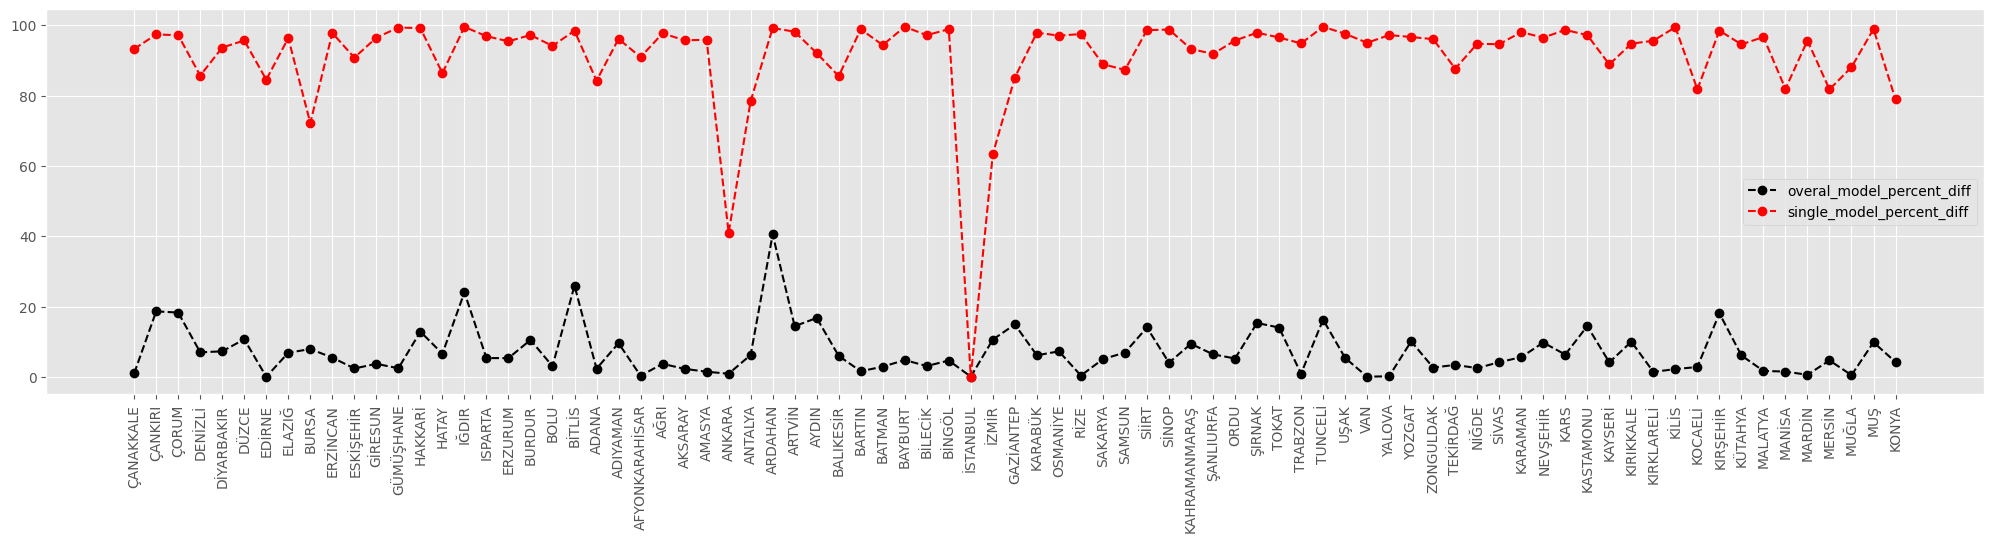

In [ ]:
plot_metrics(results_df, col_x="province", col_y1="overal_model_percent_diff", col_y2="single_model_percent_diff")

Shape of dataframe is :  (81, 8)


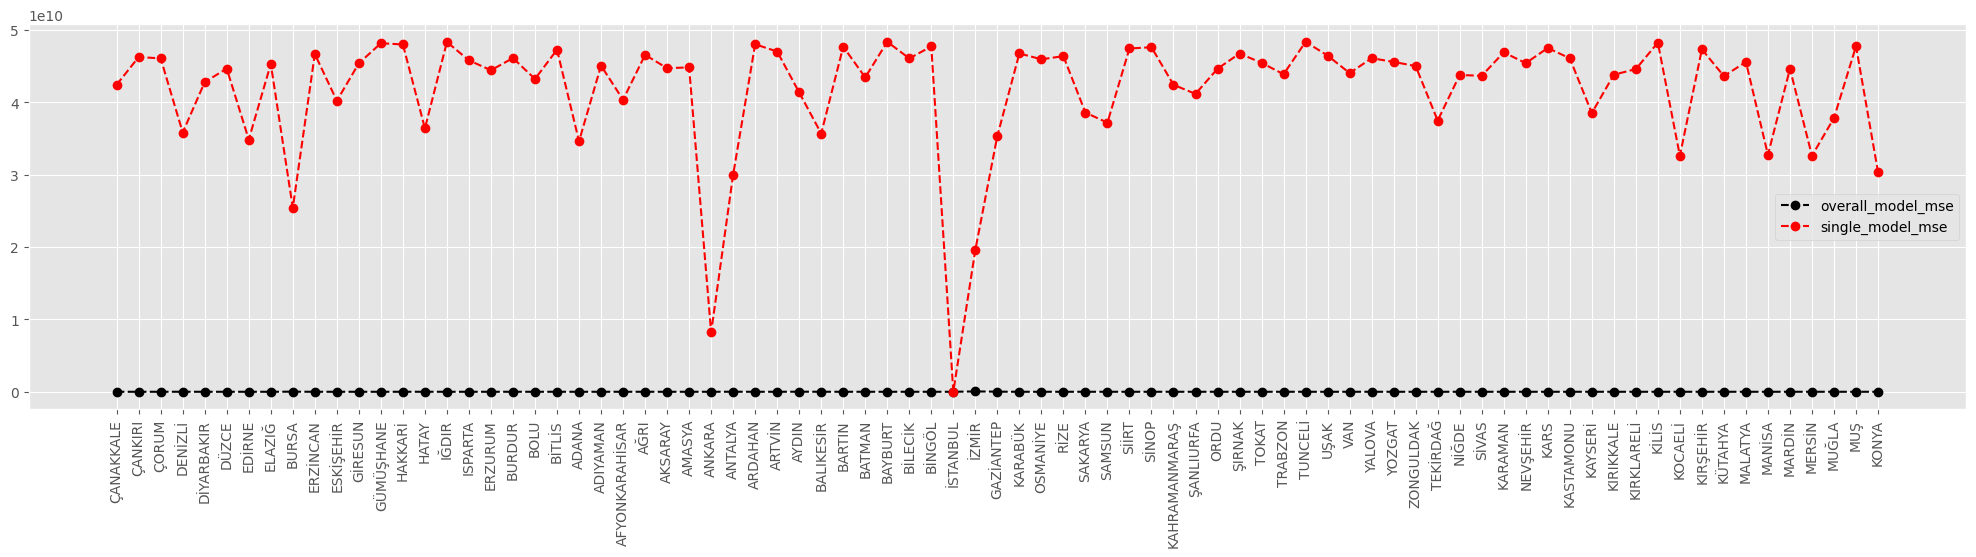

In [ ]:
plot_metrics(results_df, col_x="province", col_y1="overall_model_mse", col_y2="single_model_mse")

Shape of dataframe is :  (72, 3)


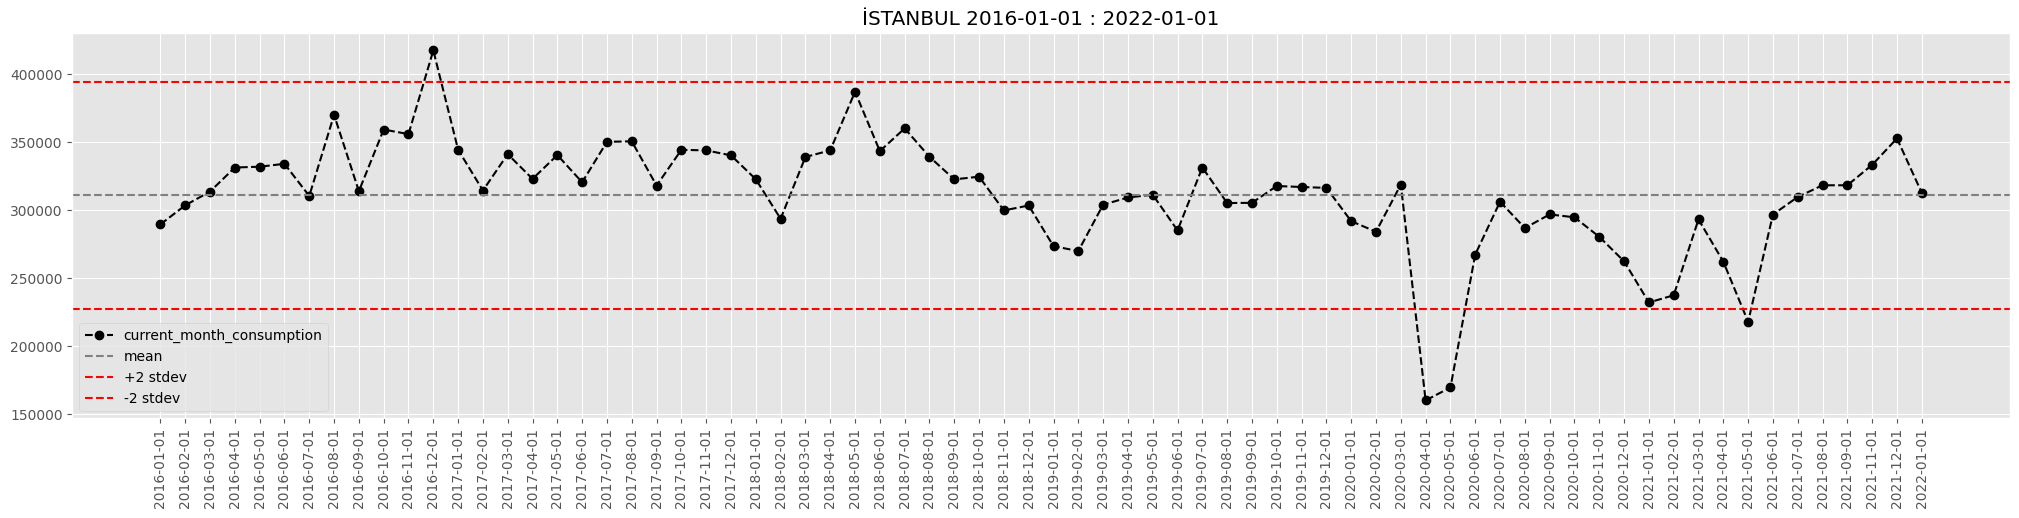

In [ ]:
plot_province(df=anomaly_corrected_df, col_x="date", col_y="current_month_consumption", province="İSTANBUL", stdev=2)

## PYCARET

In [ ]:
anomaly_corrected_df.head()

,date,province,current_month_consumption
5433,2016-01-01,ÇANAKKALE,10286.528
5434,2016-01-01,ÇANKIRI,3082.148
5435,2016-01-01,ÇORUM,7218.320
5436,2016-01-01,DENİZLİ,31509.926
5437,2016-01-01,DİYARBAKIR,9068.408


In [ ]:
from pycaret.time_series import *
s = setup(anomaly_corrected_df, fh = 3, fold = 5, session_id = 123)


ValueError: The index of your 'data' is of type '<class 'pandas.core.indexes.numeric.Int64Index'>'. If the 'data' index is not of one of the following types: <class 'pandas.core.indexes.period.PeriodIndex'>, <class 'pandas.core.indexes.datetimes.DatetimeIndex'>, then 'seasonal_period' must be provided. Refer to docstring for options.

In [ ]:
best = compare_models()

## Deep Learning

## ARIMA

## Notes

## Literature Review

In [ ]:
"""Features Engineering TODO"""
# geçen sene aynı aydaki tüketim (auto regressive feature)
# geçen ayki tüketim (auto regressive feature)
# kaçıncı çeyrek (date-time feature)
# yil (date-time feature)
# kaçıncı ay (date-time feature)
# her bir aya son 12 ayki toplam tüketim (window feature)
# her ile göre özelliştir?

In [ ]:
pgops.shutdown()

In [ ]:
"""Features Engineering TODO"""
# geçen sene aynı aydaki tüketim (auto regressive feature)
# geçen ayki tüketim (auto regressive feature)
# kaçıncı çeyrek (date-time feature)
# yil (date-time feature)
# kaçıncı ay (date-time feature)
# her bir aya son 12 ayki toplam tüketim (window feature)
# her ile göre özelliştir?

In [ ]:
"""Motorin tüketimini etkileyen faktörler"""
# 1- O aydaki resmi tatil günü sayısı
# 2- O aydaki okulların tatil günü sayısı
# 3- Motorin üzerindeki vergi
# 4- Motorin fiyatları/Asgari Ücret

In [ ]:
"""Motorin fiyatlarını etkileyen faktörler"""
# 1- Ham Petrol Fiyatları (Ham petrol fiyatlarını brent petrol fiyatları gösterge olarak kabul ediliyor)
# 2- Dolar kuru
# 3- KDV miktarı
# 4- ÖTV miktarı

In [ ]:
"""Crude Oil (Ham Petrol) fiyatlarını etkileyen faktörler"""
# https://www.forbes.com/sites/forbesbooksauthors/2021/01/25/factors-that-influence-pricing-of-oil-and-gas/?sh=29d99652338d
# 5- Demand
# 6- Supply

In [ ]:
# dimdate table
# date dimension table 
# türkiye resmi tarihler tablosu (kaggle)
# türkiye tatil günleri tablosu (kaggle)
# https://www.kaggle.com/datasets/frtgnn/turkish-calendar
# https://www.ahmetkaymaz.com/2008/02/27/sqlde-ozet-tarih-tablosu-date-dimension-table/